In [1]:
%matplotlib inline

#visualizations
import matplotlib 
import matplotlib.pylab as plt
#core imports
import numpy as np


#NN
import tensorflow as tf

In [2]:
#GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [3]:
#NP
from npfunc import get_z_params, loglikelihood1, loglikelihood2, KLqp_gauss
from npfunc import map_xy_to_z_params, posterior_predict, init_NP

## Generate data

In [4]:
def f(x):
    """The function to predict."""
    #return x * np.sin(x)
    return np.sin(x)

In [5]:
#range for predictions and true values
x_t = np.atleast_2d(np.linspace(-6, 6, 100)).T.astype(np.float32)
y_t = f(x_t).astype(np.float32)

In [6]:
#training set 
x_test = np.array([[-2], [-1], [0], [1], [2]])
y_test = f(x_test)

## Fit with GP

In [7]:
#fit with a GP
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(x_test, y_test)
y_pred, sigma = gp.predict(x_t, return_std=True)

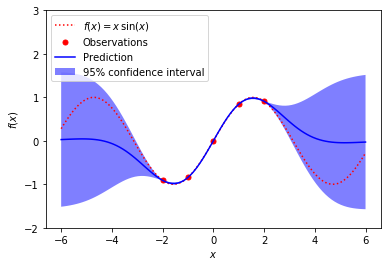

In [8]:
fig = plt.figure()
plt.plot(x_t, f(x_t), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(x_test, y_test[:,0], 'r.', markersize=10, label=u'Observations')
plt.plot(x_t, y_pred[:,0], 'b-', label=u'Prediction')
plt.fill(np.concatenate([x_t, x_t[::-1]]),
         np.concatenate([y_pred[:,0] - 1.9600 * sigma,
                        (y_pred[:,0] + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-2, 3)
plt.legend(loc='upper left')

## Fit with NP

In [9]:
#network parameters
dim_r = 2
dim_z = 2
dim_h_hidden = 8
dim_g_hidden = 8

In [10]:
#create placeholders for the data
x_context = tf.placeholder(tf.float32, shape=(None, 1))
y_context = tf.placeholder(tf.float32, shape=(None, 1))
x_target = tf.placeholder(tf.float32, shape=(None, 1))
y_target = tf.placeholder(tf.float32, shape=(None, 1))

In [11]:
#initialize 
train_op_and_loss = init_NP(x_context, y_context, x_target, y_target, dim_h_hidden, dim_g_hidden, dim_r, dim_z, 0.001)

In [12]:
init = tf.global_variables_initializer()

In [13]:
sess = tf.InteractiveSession()

In [14]:
sess.run(init)

In [15]:
n_iter = 10000
save_freq = 500

n_draws = 50
eps_value = np.random.randn(n_draws, dim_r)
epsilon = tf.constant(eps_value, dtype=tf.float32)


predict_op = posterior_predict(x_test, y_test, x_t, dim_h_hidden, dim_g_hidden, dim_r, dim_z, epsilon, 1)

y_hist = np.zeros(shape=(n_iter//save_freq, x_t.shape[0], n_draws))
hist_i = 0

In [16]:
for i in range(n_iter):

    #choose a random number of points from training set 
    N = np.random.randint(1, x_test.shape[0])
    x_c_id = np.random.randint(1, x_test.shape[0], size=N)
    x_c = x_test[x_c_id, :]
    y_c = y_test[x_c_id, :]


    a = sess.run(train_op_and_loss, feed_dict={x_context: x_c, y_context: y_c, x_target:x_t, y_target:y_t})

    if(i % save_freq == 0):
        
        print(i, a[1])
        y_star_mat = sess.run(predict_op)
        y_hist[hist_i] = y_star_mat[0]
        hist_i += 1

0 169.39076
500 22.459192
1000 20.851784
1500 20.248453
2000 18.745691
2500 16.358562
3000 13.694395
3500 8.745215
4000 4.4704776
4500 2.2279563
5000 1.3087807
5500 1.0214616
6000 0.94039005
6500 0.9122543
7000 0.8741502
7500 0.818759
8000 0.77137643
8500 0.5877009
9000 0.33315644
9500 0.17166145


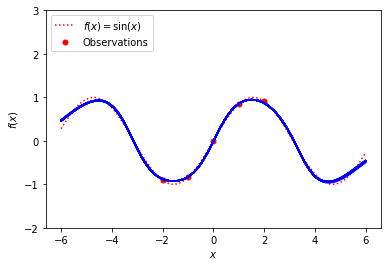

In [19]:
fig = plt.figure()
plt.plot(x_t, f(x_t), 'r:', label=u'$f(x) = \sin(x)$')
plt.plot(x_test, y_test[:,0], 'r.', markersize=10, label=u'Observations')
for i in range(50):
    plt.plot(x_t, y_star_mat[0][:, i], 'b-')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-2, 3)
plt.legend(loc='upper left')

In [18]:
sess.close()